# UrbanEye Dataset Preprocessing Pipeline

This notebook handles preprocessing of the UrbanEye dataset through these key steps:

1. **Environment Setup**  
   - Install required packages  
   - Import necessary libraries  

2. **Dataset Acquisition**  
   - Download dataset from Google Drive  
   - Extract ZIP file  

3. **Data Inspection**  
   - Load and preview training CSV  
   - Filter out missing images  

4. **Stratified Splitting**  
   - 70-15-15 train-val-test split  
   - Remove under-represented classes (<2 samples)  

5. **Class Analysis**  
   - Generate class distribution statistics  
   - Visualize split distributions  

6. **Dataset Preparation**  
   - Create split DataFrames  
   - Generate comprehensive statistics  

In [18]:
!pip install -U scikit-learn

In [19]:
!pip install gdown

In [20]:
import pandas as pd
import numpy as np
import os
import shutil
from sklearn.model_selection import train_test_split
from PIL import Image
from pathlib import Path

In [21]:
DATASET_ROOT_FOLDER = "../datasets/urbanEye"
ORIGINAL_FOLDER = f"{DATASET_ROOT_FOLDER}/original_dataset"
# # ORIGINAL_IMAGES_ROOT = DATSET_ROOT_FOLDER / '/images'
IMAGES_ROOT = f"{DATASET_ROOT_FOLDER}/dataset/images"
# DRAWN_ROOT = f"{DATASET_ROOT_FOLDER}/dataset/drawn"
LABEL_ROOT = f"{DATASET_ROOT_FOLDER}/dataset/labels"
# TRAIN_CSV_FILE = f"{DATASET_ROOT_FOLDER}/dataset/train.csv"
# TEST_CSV_FILE = f"{DATASET_ROOT_FOLDER}/dataset/test.csv"

# Download Dataset

In [22]:
import gdown

# Google Drive file ID
# file_id = "1ULqYtd9yomeGz53WBhgRdPRFB37ppeDU"
# https://drive.google.com/file/d/189wsYonCa5DeO6q3MMTUcMBYyLNkgubv/view?usp=sharing
file_id = "189wsYonCa5DeO6q3MMTUcMBYyLNkgubv"

# Output file name
output = f"{DATASET_ROOT_FOLDER}/dataset.zip"
if os.path.exists(output):
    print("\033[91m" + f"File {output} already exists." + "\033[0m")
else:
    if not os.path.isdir(DATASET_ROOT_FOLDER):
        os.makedirs(DATASET_ROOT_FOLDER)
    # Download the file
    gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)

File ../datasets/urbanEye/dataset.zip already exists.


# Extract Zip file

In [23]:
import zipfile
import os

if os.path.isdir(ORIGINAL_FOLDER):
    print("\033[91m" + f"Directory {ORIGINAL_FOLDER} already exists." + "\033[0m")
else:
    # Extract the ZIP file
    with zipfile.ZipFile(f"{DATASET_ROOT_FOLDER}/dataset.zip", "r") as zip_ref:
        zip_ref.extractall(ORIGINAL_FOLDER)

    # Remove the ZIP file to save space
    #os.remove("dataset.zip")

    print("Dataset extracted successfully!")

Directory ../datasets/urbanEye/original_dataset already exists.


#Load CSV

In [24]:
df = pd.read_csv(f"{ORIGINAL_FOLDER}/dataset/train.csv")
df.head()

,class,image_path,name,xmax,xmin,ymax,ymin
0,3.0,4a48c42c9579ec0399e6c5a3e825e765.jpg,GARBAGE,797.0,701.0,262.0,211.0
1,3.0,4a48c42c9579ec0399e6c5a3e825e765.jpg,GARBAGE,932.0,786.0,329.0,238.0
2,3.0,4a48c42c9579ec0399e6c5a3e825e765.jpg,GARBAGE,736.0,657.0,275.0,229.0
3,7.0,ea906a663da6321bcef78be4b7d1afff.jpg,BAD_BILLBOARD,986.0,786.0,136.0,0.0
4,8.0,1c7d48005a12d1b19261b8e71df7cafe.jpg,SAND_ON_ROAD,667.0,549.0,228.0,179.0


# Filter to available images only

In [25]:
image_dir = Path(f"{ORIGINAL_FOLDER}/dataset/images")
df['filename'] = df['image_path'].apply(lambda x: Path(x).name)
available_images = set(os.listdir(image_dir))
df = df[df['filename'].isin(available_images)]
print(f"Filtered dataset: {len(df)} annotations")
df.head()

Filtered dataset: 19950 annotations


,class,image_path,name,xmax,xmin,ymax,ymin,filename
0,3.0,4a48c42c9579ec0399e6c5a3e825e765.jpg,GARBAGE,797.0,701.0,262.0,211.0,4a48c42c9579ec0399e6c5a3e825e765.jpg
1,3.0,4a48c42c9579ec0399e6c5a3e825e765.jpg,GARBAGE,932.0,786.0,329.0,238.0,4a48c42c9579ec0399e6c5a3e825e765.jpg
2,3.0,4a48c42c9579ec0399e6c5a3e825e765.jpg,GARBAGE,736.0,657.0,275.0,229.0,4a48c42c9579ec0399e6c5a3e825e765.jpg
3,7.0,ea906a663da6321bcef78be4b7d1afff.jpg,BAD_BILLBOARD,986.0,786.0,136.0,0.0,ea906a663da6321bcef78be4b7d1afff.jpg
4,8.0,1c7d48005a12d1b19261b8e71df7cafe.jpg,SAND_ON_ROAD,667.0,549.0,228.0,179.0,1c7d48005a12d1b19261b8e71df7cafe.jpg


# Split Data
## 70-15-15
## Drop classes with less than 2 samples

In [26]:
from sklearn.model_selection import train_test_split

# Determine predominant class per image for stratification
image_classes = df.groupby('filename')['class'].agg(lambda x: x.mode()[0]).reset_index()
# Count occurrences per class
class_counts = image_classes['class'].value_counts()


# Automatically extract class names from the dataframe
class_id_to_name = df[['class', 'name']].drop_duplicates().sort_values('class').set_index('class')['name'].to_dict()

# Prepare display table sorted by class ID
summary_table = sorted([
    (int(cls_id), class_id_to_name.get(int(cls_id), f"Class {int(cls_id)}"), count)
    for cls_id, count in class_counts.items()
], key=lambda x: x[0])

from tabulate import tabulate
print("\nClass ID | Class Name | Image Count")
print(tabulate(summary_table, headers=["Class ID", "Class Name", "Image Count"], tablefmt="grid"))


# Keep only classes with at least 2 samples
valid_classes = class_counts[class_counts >= 2].index

# CLASS_NAMES = [class_id_to_name[int(cls_id)] for cls_id in valid_classes]
# print("\nValid Class Names:", CLASS_NAMES)


# Print dropped classes summary
dropped_classes = class_counts[class_counts < 2]


if not dropped_classes.empty:
    dropped_summary = [(int(cls_id), class_id_to_name.get(int(cls_id), f"Class {int(cls_id)}"), count)
                   for cls_id, count in dropped_classes.items()]
    print("\nDropped Classes (Less than 2 samples):")
    print(tabulate(dropped_summary, headers=["Class ID", "Class Name", "Image Count"], tablefmt="grid"))


# Filter your image_classes DataFrame
image_classes_valid = image_classes[image_classes['class'].isin(valid_classes)]

# First split (70% train, 30% temp), stratified & shuffled
train_imgs, temp_imgs = train_test_split(
    image_classes_valid,
    test_size=0.3,
    stratify=image_classes_valid['class'],
    shuffle=True,
    random_state=42
)

# Second split temp into eval and test (each 15%), stratified & shuffled
eval_imgs, test_imgs = train_test_split(
    temp_imgs,
    test_size=0.5,
    stratify=temp_imgs['class'],
    shuffle=True,
    random_state=42
)

# Extract filenames
train_imgs = train_imgs['filename'].tolist()
eval_imgs = eval_imgs['filename'].tolist()
test_imgs = test_imgs['filename'].tolist()

# Output counts
print(f"Train images: {len(train_imgs)}")
print(f"Eval images: {len(eval_imgs)}")
print(f"Test images: {len(test_imgs)}")


Class ID | Class Name | Image Count
+------------+-------------------+---------------+
|   Class ID | Class Name        |   Image Count |
+============+===================+===============+
|          0 | GRAFFITI          |           532 |
+------------+-------------------+---------------+
|          1 | FADED_SIGNAGE     |            64 |
+------------+-------------------+---------------+
|          2 | POTHOLES          |          1045 |
+------------+-------------------+---------------+
|          3 | GARBAGE           |          3315 |
+------------+-------------------+---------------+
|          4 | CONSTRUCTION_ROAD |           921 |
+------------+-------------------+---------------+
|          5 | BROKEN_SIGNAGE    |            51 |
+------------+-------------------+---------------+
|          6 | BAD_STREETLIGHT   |             1 |
+------------+-------------------+---------------+
|          7 | BAD_BILLBOARD     |           800 |
+------------+-------------------+-----------

In [27]:
# Re-run after kernel reset
import pandas as pd
from pathlib import Path
from collections import defaultdict

from tabulate import tabulate

CLASS_NAMES = [
    "GRAFFITI", "FADED_SIGNAGE", "POTHOLES", "GARBAGE",
    "CONSTRUCTION_ROAD", "BROKEN_SIGNAGE", "BAD_STREETLIGHT",
    "BAD_BILLBOARD", "SAND_ON_ROAD", "CLUTTER_SIDEWALK", "UNKEPT_FACADE"
]

# Reload CSV and images if needed
df = pd.read_csv(f"{ORIGINAL_FOLDER}/dataset/train.csv")
df['filename'] = df['image_path'].apply(lambda x: Path(x).name)

# Reload saved splits (if not available, redefine)
# Assuming variables train_imgs, eval_imgs, test_imgs already exist
try:
    train_imgs, eval_imgs, test_imgs
except NameError:
    # Fallback: use all data as one group
    train_imgs = df['filename'].unique().tolist()
    eval_imgs = []
    test_imgs = []

# Create split DataFrames
df_train = df[df['filename'].isin(train_imgs)].copy()
df_eval = df[df['filename'].isin(eval_imgs)].copy()
df_test = df[df['filename'].isin(test_imgs)].copy()

# Function to get image and class stats
def get_stats(df_split, split_name):
    image_count = df_split['filename'].nunique()
    class_distribution = df_split['class'].value_counts().sort_index()
    # class_distribution.index = [f"class_{i}" for i in class_distribution.index]
    class_distribution.index = [f"{int(i)}: {CLASS_NAMES[int(i)]}" for i in class_distribution.index]
    return pd.DataFrame({
        "Split": split_name,
        "Image Count": image_count,
        **class_distribution.to_dict()
    }, index=[0])

# Generate summary
train_stats = get_stats(df_train, "Train")
eval_stats = get_stats(df_eval, "Eval")
test_stats = get_stats(df_test, "Test")

# Combine
summary_df = pd.concat([train_stats, eval_stats, test_stats], ignore_index=True).fillna(0)
summary_df.set_index("Split", inplace=True)

print("\n🖼️ Clases distribution")
print(tabulate(summary_df.T.reset_index(), headers="keys", tablefmt="grid"))


🖼️ Clases distribution
+----+----------------------+---------+--------+--------+
|    | index                |   Train |   Eval |   Test |
+====+======================+=========+========+========+
|  0 | Image Count          |    5511 |   1181 |   1181 |
+----+----------------------+---------+--------+--------+
|  1 | 0: GRAFFITI          |     779 |    174 |    171 |
+----+----------------------+---------+--------+--------+
|  2 | 1: FADED_SIGNAGE     |      78 |     11 |     18 |
+----+----------------------+---------+--------+--------+
|  3 | 2: POTHOLES          |    1864 |    373 |    388 |
+----+----------------------+---------+--------+--------+
|  4 | 3: GARBAGE           |    5972 |   1315 |   1310 |
+----+----------------------+---------+--------+--------+
|  5 | 4: CONSTRUCTION_ROAD |    1908 |    421 |    401 |
+----+----------------------+---------+--------+--------+
|  6 | 5: BROKEN_SIGNAGE    |      58 |     14 |     11 |
+----+----------------------+---------+--------+

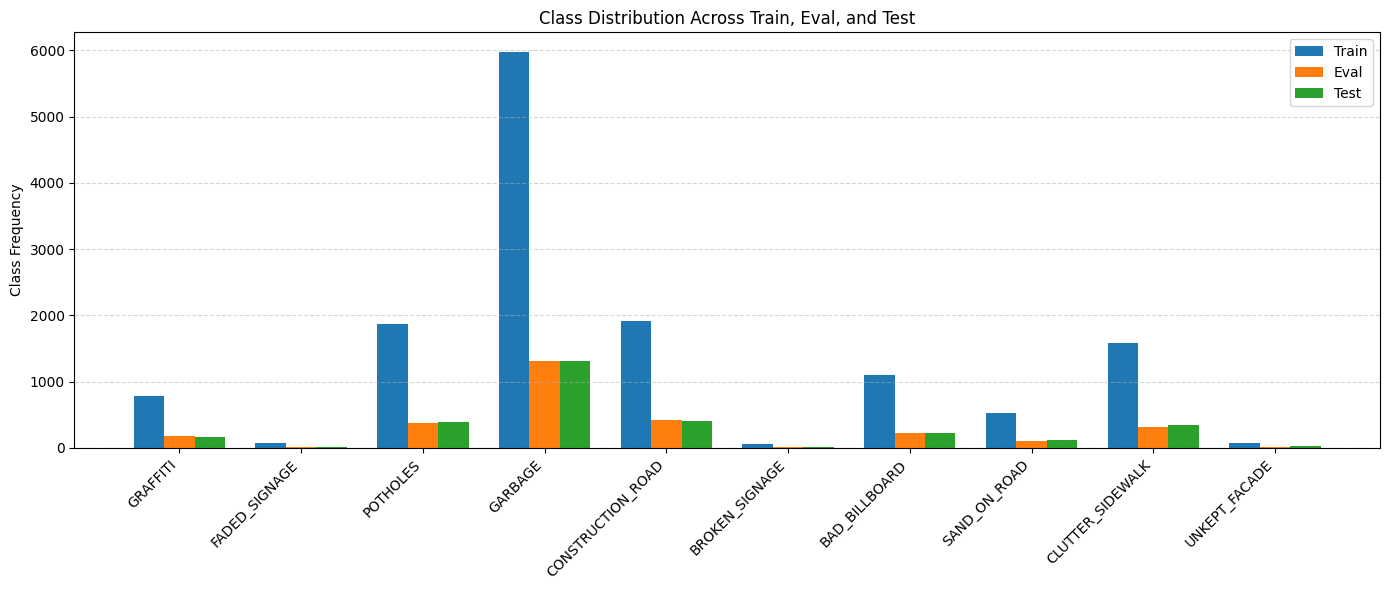

In [28]:
import matplotlib.pyplot as plt

# Flatten the class distribution for bar plotting
class_columns = [col for col in summary_df.columns if col not in ["Image Count"]]
class_counts = summary_df[class_columns].T
class_counts.columns.name = None
class_counts.reset_index(inplace=True)
class_counts[['Class ID', 'Class Name']] = class_counts['index'].str.split(": ", expand=True)
class_counts.drop(columns=['index'], inplace=True)

# Convert counts to integers
for col in ["Train", "Eval", "Test"]:
    if col in class_counts.columns:
        class_counts[col] = class_counts[col].astype(int)

# Plot
plt.figure(figsize=(14, 6))
bar_width = 0.25
x = range(len(class_counts))

plt.bar([i - bar_width for i in x], class_counts["Train"], width=bar_width, label="Train")
plt.bar(x, class_counts["Eval"], width=bar_width, label="Eval")
plt.bar([i + bar_width for i in x], class_counts["Test"], width=bar_width, label="Test")

plt.xticks(x, class_counts["Class Name"], rotation=45, ha="right")
plt.ylabel("Class Frequency")
plt.title("Class Distribution Across Train, Eval, and Test")
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


# Dataset Preparation and Image Resizing

In [29]:
from tqdm import tqdm
from pathlib import Path
from PIL import Image

# Correct label conversion with scaling from original 1920x1080 to 640x640
def convert_to_yolo(row, img_w=640, img_h=640):
    # Step 1: adjust coordinates from CSV format (halved res) → full res
    xmin = row['xmin'] * 2
    xmax = row['xmax'] * 2
    ymin = row['ymin'] * 2
    ymax = row['ymax'] * 2

    # Step 2: scale coordinates from 1920x1080 → 640x640
    scale_x = img_w / 1920
    scale_y = img_h / 1080

    xmin *= scale_x
    xmax *= scale_x
    ymin *= scale_y
    ymax *= scale_y

    # Step 3: compute YOLO format
    x_center = ((xmin + xmax) / 2) / img_w
    y_center = ((ymin + ymax) / 2) / img_h
    width = (xmax - xmin) / img_w
    height = (ymax - ymin) / img_h

    return (
        int(row['class']),
        min(max(x_center, 0.0), 1.0),
        min(max(y_center, 0.0), 1.0),
        min(max(width, 0.0), 1.0),
        min(max(height, 0.0), 1.0)
    )

target_size = (640, 640)
invalid_classes = {6}
def prepare_data(image_list, split):
    Path(f"{IMAGES_ROOT}/{split}").mkdir(parents=True, exist_ok=True)
    Path(f"{LABEL_ROOT}/{split}").mkdir(parents=True, exist_ok=True)

    for img_name in tqdm(image_list, desc=f"Processing {split} images"):
        img_annotations = df[df['filename'] == img_name]

        # Filter out invalid class rows before conversion
        valid_annotations = img_annotations[~img_annotations['class'].isin(invalid_classes)]
        # img_name.contains("2bb02e9237647d20bf2188ba7b798f0a")  # Ensure the image name is correct
        if valid_annotations.empty:
            continue
        # Resize images
        img_path = image_dir / img_name
        img = Image.open(img_path)
        img_resized = img.resize(target_size)
        img_resized.save(f"{IMAGES_ROOT}/{split}/{img_name}")

        # Convert labels to YOLO format using corrected function
        yolo_annotations = valid_annotations.apply(
            lambda row: convert_to_yolo(row, target_size[0], target_size[1]), axis=1
        ).tolist()

        label_path = Path(f"{LABEL_ROOT}/{split}/{Path(img_name).stem}.txt")
        with open(label_path, "w") as f:
            for annotation in yolo_annotations:
                cls_id, xc, yc, w, h = annotation
                f.write(f"{int(cls_id)} {xc:.6f} {yc:.6f} {w:.6f} {h:.6f}\n")

# Create your splits
prepare_data(train_imgs, "train")
prepare_data(eval_imgs, "eval")
prepare_data(test_imgs, "test")

Processing test images: 100%|██████████| 1181/1181 [00:27<00:00, 43.34it/s]


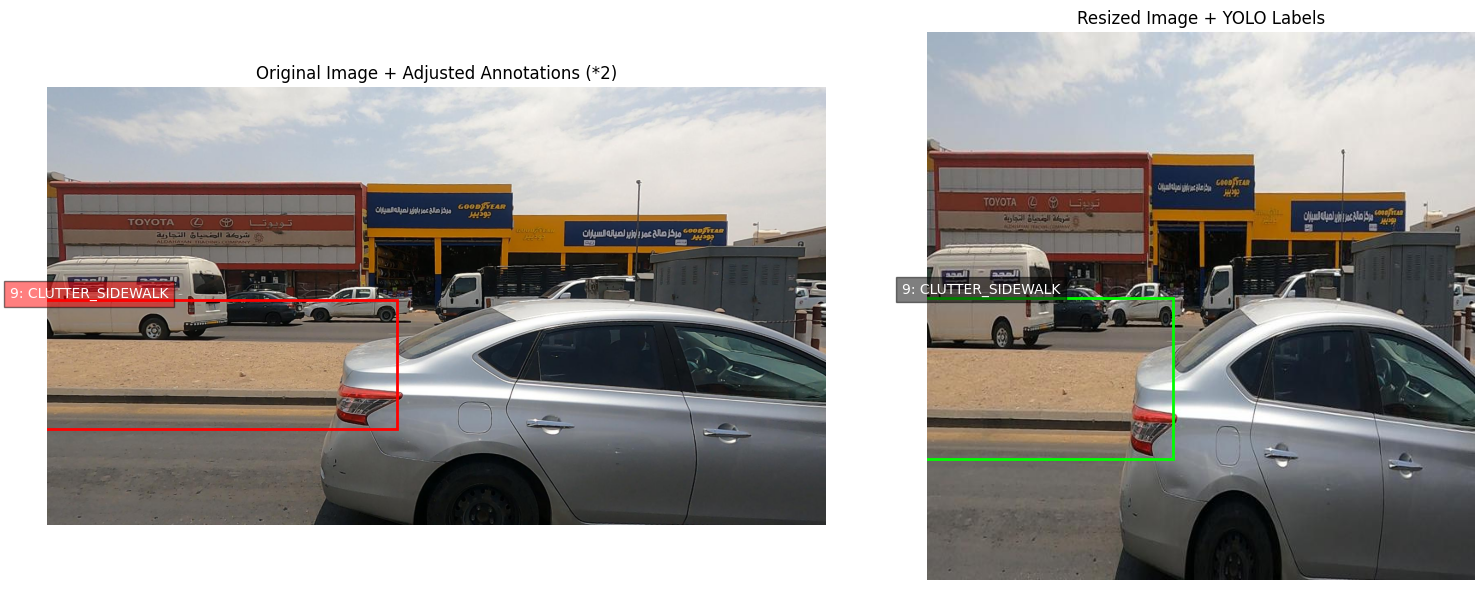

In [30]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from pathlib import Path
import random

# Map class ID to name using df['class'] and df['name']
class_id_to_name = df[['class', 'name']].drop_duplicates().sort_values('class').set_index('class')['name'].to_dict()

def plot_original_and_resized(img_name):
    orig_img_path = image_dir / img_name
    resized_img_path = Path(f"{IMAGES_ROOT}/train/{img_name}")
    resized_label_path = Path(f"{LABEL_ROOT}/train/{Path(img_name).stem}.txt")

    # Load original image and dimensions
    orig_img = cv2.imread(str(orig_img_path))
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

    # Load original annotations from df (and apply *2 adjustment)
    img_annotations = df[df['filename'] == img_name]

    # Plot original
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    axs[0].imshow(orig_img)
    axs[0].set_title("Original Image + Adjusted Annotations (*2)")
    for _, row in img_annotations.iterrows():
        cls_id = int(row['class'])
        x1, y1 = int(row['xmin'] * 2), int(row['ymin'] * 2)
        x2, y2 = int(row['xmax'] * 2), int(row['ymax'] * 2)
        class_name = class_id_to_name.get(cls_id, str(cls_id))
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor='red', facecolor='none')
        axs[0].add_patch(rect)
        axs[0].text(x1, y1 - 5, f"{cls_id}: {class_name}", color='white', fontsize=10,
                    bbox=dict(facecolor='red', alpha=0.5))
    axs[0].axis('off')

    # Load resized image
    resized_img = cv2.imread(str(resized_img_path))
    resized_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
    h, w = resized_img.shape[:2]

    # Load and plot YOLO labels on resized image
    axs[1].imshow(resized_img)
    axs[1].set_title("Resized Image + YOLO Labels")
    with open(resized_label_path, 'r') as f:
        for line in f:
            cls_id, x, y, bw, bh = map(float, line.strip().split())
            x1 = int((x - bw / 2) * w)
            y1 = int((y - bh / 2) * h)
            x2 = int((x + bw / 2) * w)
            y2 = int((y + bh / 2) * h)
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                     linewidth=2, edgecolor='lime', facecolor='none')
            axs[1].add_patch(rect)
            class_name = class_id_to_name.get(int(cls_id), str(int(cls_id)))
            axs[1].text(x1, y1 - 5, f"{int(cls_id)}: {class_name}", color='white', fontsize=10,
                        bbox=dict(facecolor='black', alpha=0.5))
    axs[1].axis('off')
    plt.tight_layout()
    plt.show()

# Example usage
plot_original_and_resized(random.choice(train_imgs))


In [31]:
from pathlib import Path
from collections import defaultdict
import pandas as pd
from IPython.display import display

# CONFIG
LABEL_DIRS = {
    "Train": Path(f"{LABEL_ROOT}/train"),
    "Eval": Path(f"{LABEL_ROOT}/eval"),
    "Test": Path(f"{LABEL_ROOT}/test")
}
CLASS_NAMES = [
    "GRAFFITI", "FADED_SIGNAGE", "POTHOLES", "GARBAGE",
    "CONSTRUCTION_ROAD", "BROKEN_SIGNAGE", "BAD_STREETLIGHT",
    "BAD_BILLBOARD", "SAND_ON_ROAD", "CLUTTER_SIDEWALK", "UNKEPT_FACADE"
]
# Recalculate summary into two tables: one for boxes, one for images
box_table = {}
image_table = {}

for source, label_dir in LABEL_DIRS.items():
    class_box_counts = defaultdict(int)
    class_image_ids = defaultdict(set)

    for label_file in label_dir.glob("*.txt"):
        with open(label_file, "r") as f:
            for line in f:
                if not line.strip():
                    continue
                cls_id = int(line.split()[0])
                class_box_counts[cls_id] += 1
                class_image_ids[cls_id].add(label_file.stem)

    for i, class_name in enumerate(CLASS_NAMES):
        if class_name not in box_table:
            box_table[class_name] = {}
            image_table[class_name] = {}
        box_table[class_name][source] = class_box_counts[i]
        image_table[class_name][source] = len(class_image_ids[i])

# Convert to DataFrames and add totals
df_boxes = pd.DataFrame(box_table).T.fillna(0).astype(int)
df_images = pd.DataFrame(image_table).T.fillna(0).astype(int)
df_boxes["Total"] = df_boxes.sum(axis=1)
df_images["Total"] = df_images.sum(axis=1)

# Tabulate both
from tabulate import tabulate
print("📦 Bounding Box Counts:")
print(tabulate(df_boxes.reset_index(), headers="keys", tablefmt="grid", showindex=False))

print("\n🖼️ Image Counts:")
print(tabulate(df_images.reset_index(), headers="keys", tablefmt="grid", showindex=False))


📦 Bounding Box Counts:
+-------------------+---------+--------+--------+---------+
| index             |   Train |   Eval |   Test |   Total |
+===================+=========+========+========+=========+
| GRAFFITI          |     779 |    174 |    171 |    1124 |
+-------------------+---------+--------+--------+---------+
| FADED_SIGNAGE     |      78 |     11 |     18 |     107 |
+-------------------+---------+--------+--------+---------+
| POTHOLES          |    1864 |    373 |    388 |    2625 |
+-------------------+---------+--------+--------+---------+
| GARBAGE           |    5972 |   1315 |   1310 |    8597 |
+-------------------+---------+--------+--------+---------+
| CONSTRUCTION_ROAD |    1908 |    421 |    401 |    2730 |
+-------------------+---------+--------+--------+---------+
| BROKEN_SIGNAGE    |      58 |     14 |     11 |      83 |
+-------------------+---------+--------+--------+---------+
| BAD_STREETLIGHT   |       0 |      0 |      0 |       0 |
+----------------

### Enhance augmentation for classes with few examples.
### Incorporate weighted or focal loss mechanisms so that errors from underrepresented classes are penalized more.
### Balance the sampling strategy so each training batch represents all classes fairly.
### Leverage transfer learning by starting from a model pretrained on a large dataset.
### Consider synthetic data generation if acquiring more real examples is not feasible.

# Generating synthetic images for the underrepresented classes:
TARGET_BOXES_PER_CLASS = 1000

In [32]:
from pathlib import Path
import os
import cv2
import numpy as np
import random
from collections import defaultdict
import pandas as pd
from tabulate import tabulate
from tqdm import tqdm

# CONFIG
IMG_DIR = Path("../datasets/urbanEye/dataset/images/train")  # path to training images
LBL_DIR = Path("../datasets/urbanEye/dataset/labels/train")  # path to corresponding YOLO label files
SYN_IMG_DIR = Path("../datasets/urbanEye/dataset/synthetic/images")
SYN_LBL_DIR = Path("../datasets/urbanEye/dataset/synthetic/labels")
SYN_IMG_DIR.mkdir(parents=True, exist_ok=True)
SYN_LBL_DIR.mkdir(parents=True, exist_ok=True)

IMG_SIZE = (640, 640)  # target size for synthetic images (must match training image size)
MAX_OBJECTS_PER_IMAGE = 3  # how many synthetic objects per image
TARGET_BOXES_PER_CLASS = 1000  # desired number of total boxes per class
MIN_BOXES_PER_CLASS = 2  # ignore classes with fewer than this number of real boxes

# Load original label counts per class
original_counts = defaultdict(int)
label_files = sorted(LBL_DIR.glob("*.txt"))

for label_file in label_files:
    with open(label_file, "r") as f:
        for line in f:
            if not line.strip():
                continue
            cls_id = int(float(line.split()[0]))  # ensure class ID is integer-safe
            original_counts[cls_id] += 1

# Remove classes with less than MIN_BOXES_PER_CLASS
valid_classes = {cls for cls, count in original_counts.items() if count >= MIN_BOXES_PER_CLASS}
original_counts = {cls: count for cls, count in original_counts.items() if cls in valid_classes}

# Determine how many more boxes each class needs
boxes_needed = {cls: max(0, TARGET_BOXES_PER_CLASS - count) for cls, count in original_counts.items()}

# Collect object crops from real images, categorized by class
object_crops = defaultdict(list)

print("Collecting object crops...")
for label_file in tqdm(label_files):
    img_path = IMG_DIR / f"{label_file.stem}.jpg"
    if not img_path.exists():
        continue
    img = cv2.imread(str(img_path))
    if img is None:
        continue
    h, w = img.shape[:2]

    with open(label_file, "r") as f:
        for line in f:
            parts = line.strip().split()
            cls_id = int(float(parts[0]))
            if cls_id not in valid_classes or boxes_needed[cls_id] == 0:
                continue
            box = list(map(float, parts[1:]))
            x_c, y_c, bw, bh = box
            x1 = int((x_c - bw / 2) * w)
            y1 = int((y_c - bh / 2) * h)
            x2 = int((x_c + bw / 2) * w)
            y2 = int((y_c + bh / 2) * h)
            crop = img[y1:y2, x1:x2]
            if crop.size > 0:
                object_crops[cls_id].append(crop)

# Begin generating synthetic images with synthetic objects
synth_counts = defaultdict(int)
image_index = 0
print("\nGenerating synthetic images...")

while any(synth_counts[c] < boxes_needed[c] for c in boxes_needed if boxes_needed[c] > 0):
    canvas = np.full((IMG_SIZE[1], IMG_SIZE[0], 3), 114, dtype=np.uint8)
    label_lines = []
    added_this_image = defaultdict(int)

    eligible_classes = [cls for cls in boxes_needed if boxes_needed[cls] > 0 and synth_counts[cls] < boxes_needed[cls]]
    if not eligible_classes:
        break

    cls_id = random.choice(eligible_classes)
    k = min(MAX_OBJECTS_PER_IMAGE, boxes_needed[cls_id] - synth_counts[cls_id])
    candidates = object_crops[cls_id]
    if not candidates:
        continue
    used = random.choices(candidates, k=k)

    for crop in used:
        ch, cw = crop.shape[:2]
        if ch >= IMG_SIZE[1] or cw >= IMG_SIZE[0]:
            continue

        max_x = IMG_SIZE[0] - cw
        max_y = IMG_SIZE[1] - ch
        x1 = random.randint(0, max_x)
        y1 = random.randint(0, max_y)
        x2 = x1 + cw
        y2 = y1 + ch

        canvas[y1:y2, x1:x2] = crop

        x_c = (x1 + x2) / 2 / IMG_SIZE[0]
        y_c = (y1 + y2) / 2 / IMG_SIZE[1]
        bw = cw / IMG_SIZE[0]
        bh = ch / IMG_SIZE[1]
        label_lines.append(f"{int(cls_id)} {x_c:.6f} {y_c:.6f} {bw:.6f} {bh:.6f}")
        synth_counts[cls_id] += 1
        added_this_image[cls_id] += 1

    if label_lines:
        name = f"synth_{image_index:04d}"
        cv2.imwrite(str(SYN_IMG_DIR / f"{name}.jpg"), canvas)
        with open(SYN_LBL_DIR / f"{name}.txt", "w") as f:
            f.write("\n".join(label_lines))
        image_index += 1

# Display synthetic generation summary
summary = {
    f"Class {cls}": {
        "Original": original_counts[cls],
        "Needed": boxes_needed[cls],
        "Generated": synth_counts[cls],
        "Total": original_counts[cls] + synth_counts[cls]
    } for cls in sorted(set(original_counts.keys()) | set(synth_counts.keys()))
}

print("\nDynamic Synthetic Box Summary")
print(tabulate(pd.DataFrame(summary).T.reset_index(), headers="keys", tablefmt="grid", showindex=False))


100%|██████████| 5511/5511 [00:35<00:00, 154.29it/s]



Generating synthetic images...

Dynamic Synthetic Box Summary
+----------+------------+----------+-------------+---------+
| index    |   Original |   Needed |   Generated |   Total |
+==========+============+==========+=============+=========+
| Class 0  |        779 |      221 |         221 |    1000 |
+----------+------------+----------+-------------+---------+
| Class 1  |         78 |      922 |         922 |    1000 |
+----------+------------+----------+-------------+---------+
| Class 2  |       1864 |        0 |           0 |    1864 |
+----------+------------+----------+-------------+---------+
| Class 3  |       5972 |        0 |           0 |    5972 |
+----------+------------+----------+-------------+---------+
| Class 4  |       1908 |        0 |           0 |    1908 |
+----------+------------+----------+-------------+---------+
| Class 5  |         58 |      942 |         942 |    1000 |
+----------+------------+----------+-------------+---------+
| Class 7  |       109

YAML Weights: [1.113, 1.2724, 0.7967, 0.4402, 0.7812, 1.2749, 1.0351, 1.1652, 0.8599, 1.2614]

📦 Box Counts per Class
+------------+-------------------+---------+------------------+--------+--------+---------+--------------+------------------------------+-----------+
|   Class ID | Class Name        |   Train |   SyntheticTrain |   eval |   test |   Total |   Raw Weight |   Normalized Weight (sum=10) |   Rounded |
+============+===================+=========+==================+========+========+=========+==============+==============================+===========+
|          0 | GRAFFITI          |     779 |              221 |    174 |    171 |    1345 |    0.0272671 |                     1.11295  |    1.113  |
+------------+-------------------+---------+------------------+--------+--------+---------+--------------+------------------------------+-----------+
|          1 | FADED_SIGNAGE     |      78 |              922 |     11 |     18 |    1029 |    0.031174  |                     1.272

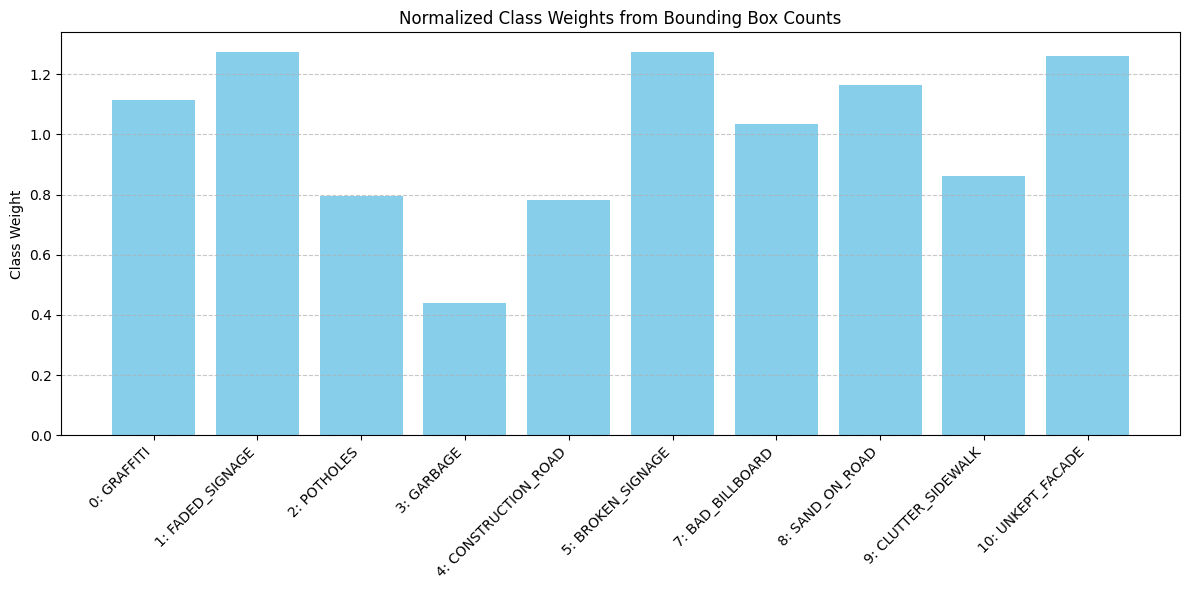


🖼️ Image Counts per Class
+------------+-------------------+---------+------------------+--------+--------+---------+
|   Class ID | Class Name        |   Train |   SyntheticTrain |   eval |   test |   Total |
+============+===================+=========+==================+========+========+=========+
|          0 | GRAFFITI          |     433 |               74 |     90 |     97 |     694 |
+------------+-------------------+---------+------------------+--------+--------+---------+
|          1 | FADED_SIGNAGE     |      60 |              308 |     10 |     12 |     390 |
+------------+-------------------+---------+------------------+--------+--------+---------+
|          2 | POTHOLES          |     799 |                0 |    168 |    169 |    1136 |
+------------+-------------------+---------+------------------+--------+--------+---------+
|          3 | GARBAGE           |    2671 |                0 |    573 |    581 |    3825 |
+------------+-------------------+---------+---------

In [33]:
from pathlib import Path
from collections import defaultdict
import pandas as pd
import numpy as np
from IPython.display import display
from tabulate import tabulate
import matplotlib.pyplot as plt

SHOW_WEIGHTS = True  # set to False to skip weight calculation
SHOW_ONLY_TOTAL = False  # set to False to skip weight calculation
# CONFIG
LABEL_DIRS = {
    "Train": Path("../datasets/urbanEye/dataset/labels/train"),
    "SyntheticTrain": Path("../datasets/urbanEye/dataset/synthetic/labels"),
    "eval": Path("../datasets/urbanEye/dataset/labels/eval"),
    "test": Path("../datasets/urbanEye/dataset/labels/test"),
}
CLASS_NAMES = [
    "GRAFFITI", "FADED_SIGNAGE", "POTHOLES", "GARBAGE",
    "CONSTRUCTION_ROAD", "BROKEN_SIGNAGE", "BAD_STREETLIGHT",
    "BAD_BILLBOARD", "SAND_ON_ROAD", "CLUTTER_SIDEWALK", "UNKEPT_FACADE"
]

# Generate summary from actual data
summary = defaultdict(dict)

for source, label_dir in LABEL_DIRS.items():
    class_counts = defaultdict(int)
    image_counts = defaultdict(set)

    for label_file in label_dir.glob("*.txt"):
        with open(label_file, "r") as f:
            for line in f:
                if not line.strip():
                    continue
                cls_id = int(line.split()[0])
                class_counts[CLASS_NAMES[cls_id]] += 1
                image_counts[CLASS_NAMES[cls_id]].add(label_file.stem)

    for cls in CLASS_NAMES:
        summary[cls][f"{source}_Boxes"] = class_counts[cls]
        summary[cls][f"{source}_Images"] = len(image_counts[cls])

# Create box and image tables
box_table = {}
image_table = {}

for name in CLASS_NAMES:
    box_table[name] = {}
    image_table[name] = {}
    for source in LABEL_DIRS:
        box_table[name][source] = summary[name].get(f"{source}_Boxes", 0)
        image_table[name][source] = summary[name].get(f"{source}_Images", 0)
    box_table[name]["Total"] = sum(box_table[name].values())
    image_table[name]["Total"] = sum(image_table[name].values())

box_table = {k: v for k, v in box_table.items() if sum(v.values()) >= 2}
image_table = {k: v for k, v in image_table.items() if k in box_table}

# Convert to DataFrames
df_boxes = pd.DataFrame.from_dict(box_table, orient="index")
df_boxes["Class ID"] = [CLASS_NAMES.index(name) for name in df_boxes.index]
df_boxes["Class Name"] = df_boxes.index
df_boxes.reset_index(drop=True, inplace=True)
df_boxes = df_boxes[["Class ID", "Class Name"] + [c for c in df_boxes.columns if c not in ["Class ID", "Class Name"]]]

df_images = pd.DataFrame.from_dict(image_table, orient="index")
df_images["Class ID"] = [CLASS_NAMES.index(name) for name in df_images.index]
df_images["Class Name"] = df_images.index
df_images.reset_index(drop=True, inplace=True)
df_images = df_images[["Class ID", "Class Name"] + [c for c in df_images.columns if c not in ["Class ID", "Class Name"]]]


if SHOW_WEIGHTS:
    # Compute normalized class weights from box totals
    df_boxes["Raw Weight"] = 1 / np.sqrt(df_boxes["Total"].clip(lower=1))  # prevent division by zero
    total_weight = df_boxes["Raw Weight"].sum()
    df_boxes["Normalized Weight (sum=10)"] = df_boxes["Raw Weight"] / total_weight * 10
    df_boxes["Rounded"] = df_boxes["Normalized Weight (sum=10)"].round(4)

    # Prepare final weight list
    yaml_weights_from_df = df_boxes["Rounded"].tolist()

    print("YAML Weights:", yaml_weights_from_df)

# Display tables
print("\n📦 Box Counts per Class")
# print(tabulate((df_boxes[['Total']] if SHOW_ONLY_TOTAL else df_boxes).reset_index().rename(columns={"index": "Class Name"}), headers="keys", tablefmt="grid"))

print(tabulate((df_boxes[['Total']] if SHOW_ONLY_TOTAL else df_boxes), headers="keys", tablefmt="grid", showindex=False))

if SHOW_WEIGHTS:
    # Plot the class weights as a bar chart
    plt.figure(figsize=(12, 6))
    x_labels = df_boxes["Class ID"].astype(str) + ": " + df_boxes["Class Name"]
    plt.bar(x_labels, df_boxes["Rounded"], color='skyblue') 
    # plt.bar(df_boxes.index, df_boxes["Rounded"], color='skyblue')
    plt.ylabel("Class Weight")
    plt.title("Normalized Class Weights from Bounding Box Counts")
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

print("\n🖼️ Image Counts per Class")
print(tabulate(df_images, headers="keys", tablefmt="grid", showindex=False))



## Update class weights from previous results to urbanEye.yaml 
### [1.113, 1.2724, 0.7967, 0.4402, 0.7812, 1.2749, 1.0351, 1.1652, 0.8599, 1.2614]

## Update detection loss.py to use class weights

# -------

Scanning ..\datasets\urbanEye\dataset\labels\train.cache... 6674 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6674/6674 [00:00<?, ?it/s]


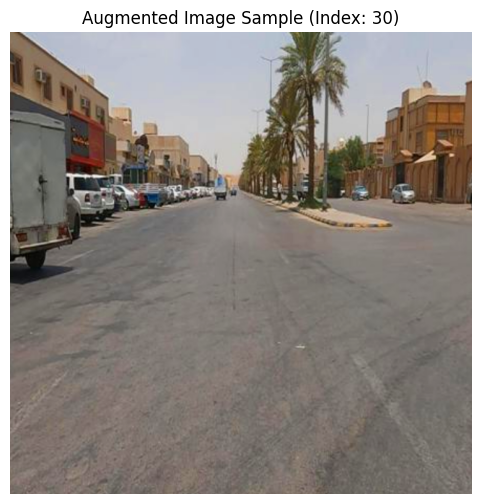

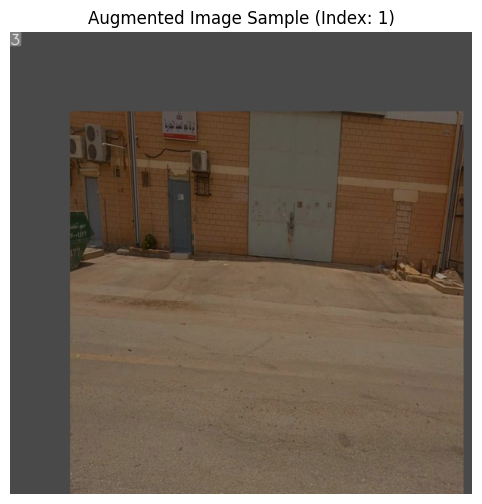

In [ ]:
from ultralytics.data.dataset import YOLODataset
from ultralytics.utils import yaml_load
from types import SimpleNamespace

# Load dataset config
data_cfg = yaml_load("ultralytics/cfg/datasets/urbanEye.yaml")
# Load your training YAML config
cfg = yaml_load("ultralytics/cfg/urbanyet-settings.yaml")

# Extract hyp as SimpleNamespace
# hyp = SimpleNamespace(**{k: v for k, v in cfg.items() if isinstance(v, (int, float, str))})
# # Build minimal hyp for augmentation preview
hyp = SimpleNamespace(
    mosaic=1.0,
    mixup=0.15,
    copy_paste=0.1,
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    degrees=0.0,
    translate=0.1,
    scale=0.5,
    shear=0.0,
    perspective=0.0,
    flipud=0.0,
    fliplr=0.5,
    copy_paste_mode="flip",
    mask_ratio=4,
    overlap_mask=True,
    bgr=0.0,
)

# hyp = SimpleNamespace(**{
#     "mosaic": 1.0,
#     "mixup": 0.3,
#     "copy_paste": 0.5,
#     "copy_paste_mode": "flip",
#     "degrees": 0,
#     "translate": 0.1,
#     "scale": 0.5,
#     "shear": 2.0,
#     "perspective": 0.0,
#     "flipud": 0.0,
#     "fliplr": 0.5,
#     "hsv_h": 0.015,
#     "hsv_s": 0.7,
#     "hsv_v": 0.4,
#     "mask_ratio": 4,
#     "overlap_mask": True,
#     "bgr": 0.0,
# })

# Create YOLO dataset with augmentation enabled
dataset = YOLODataset(
    img_path=data_cfg['train'],
    data=data_cfg,
    task="detect",
    imgsz=640,
    augment=True,
    hyp=hyp,
)

# Sample and visualize one real and one synthetic image (if both are mixed in the dataset)
from ultralytics.utils.plotting import Annotator

def show_augmented_sample(index):
    sample = dataset[index]
    img = sample['img'].permute(1, 2, 0).numpy().astype('uint8')
    bboxes = sample['bboxes']
    classes = sample['cls']

    # Ensure image is contiguous for Annotator
    img = np.ascontiguousarray(img)

    annotator = Annotator(img, example=str(classes))
    for box, cls_id in zip(bboxes, classes):
        annotator.box_label(box, label=str(int(cls_id)))

    plt.figure(figsize=(8, 6))
    plt.imshow(annotator.im)
    plt.title(f"Augmented Image Sample (Index: {index})")
    plt.axis('off')
    plt.show()

# Show two samples
show_augmented_sample(30)
show_augmented_sample(1)
